In [1]:

import torch.nn as nn
import torch.nn.functional as F


## 실제 데이터 모델링

In [2]:
## Step1 : 데이터 수집

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

X, y = make_classification(
    n_samples=300,      # 샘플 개수 (행 개수, 데이터 포인트 수)
    n_features=2,       # 특징(컬럼) 개수
    n_redundant=0,      # 쓸모 없는(다른 특성과 선형결합으로 표현되는) feature 개수
    n_informative=1,    # 실제로 분류에 도움이 되는 feature 개수
    n_clusters_per_class=1, # 각 클래스(class)를 몇 개의 클러스터로 생성할지
    random_state=33     # 랜덤 시드 (재현 가능성 확보)
)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, shuffle=True)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

X_train.shape, X_test.shape

print(X)
print(y)

[[ 1.80227255e+00 -1.42962864e+00]
 [-1.71548469e+00  1.93574500e+00]
 [-4.63792502e-01  3.48464829e-01]
 [ 6.66412645e-01 -3.16657630e-01]
 [ 1.41018470e-01  2.63162767e+00]
 [-3.52486887e-01  1.76578131e-02]
 [ 2.35216532e+00  1.21377022e-01]
 [ 2.50220461e+00  7.47085897e-01]
 [ 2.52385903e-01  5.89846730e-02]
 [ 9.76568889e-01  9.16210345e-02]
 [-7.44927761e-01 -2.80956778e-02]
 [ 1.09018050e+00  7.29986431e-01]
 [-1.29134919e+00 -1.84338723e-01]
 [ 1.03305033e+00 -6.61757038e-01]
 [ 7.60216117e-01  1.09808364e+00]
 [-1.28661727e+00 -6.13535145e-01]
 [ 7.85596054e-01 -1.60248278e-01]
 [ 1.42742493e+00  1.76735838e-02]
 [ 1.25954271e+00 -1.18892164e+00]
 [ 9.21549042e-01 -1.09652413e+00]
 [-6.33233795e-01 -5.91836068e-01]
 [ 1.27258075e+00  7.64034689e-01]
 [-3.22838879e-01 -1.05521943e+00]
 [-2.37594565e-02 -1.71741412e+00]
 [ 3.08138099e-01  3.92756259e-01]
 [-6.83153552e-01 -7.62953346e-03]
 [ 1.75599363e+00  3.45330061e-01]
 [-3.29998966e-01  7.07367241e-01]
 [ 2.04684470e+00 -2

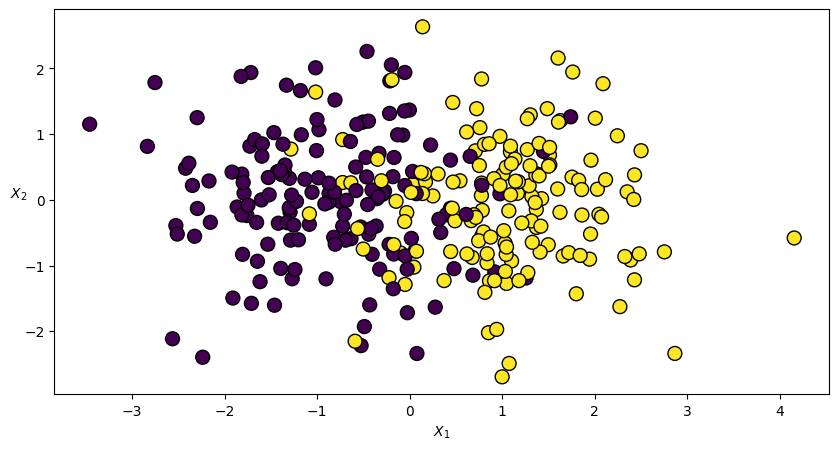

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, edgecolors="k")
plt.xlabel('$X_1$')
plt.ylabel('$X_2$', rotation=0)
plt.show()

In [4]:
## Step 2 : 모델 만들기

class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = torch.nn.Linear(in_features=2, out_features=10)
        self.layer2 = torch.nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        x = F.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x

model = SimpleNN()
print(model)

SimpleNN(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=1, bias=True)
)


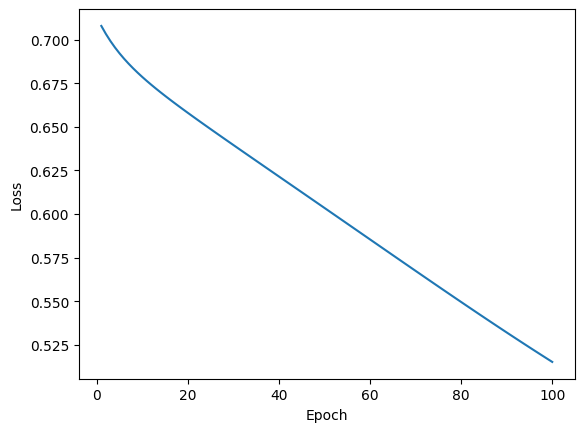

In [5]:
### Step 3. 모델 학습시키기

LR = 1e-1
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

EPOCH = 100
BATCH_SIZE = 210

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

losses = []

for epoch in range(EPOCH):
    model.train()
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad() # 초기화
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())

plt.plot(range(1, EPOCH+1), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [6]:
### Step 4 모델 테스트하기
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)
    y_pred_test = (y_pred_test >= 0.5).float()
    accuracy = (y_pred_test.eq(y_test).sum() / y_test.size(0)).item()

print("Test Accuracy:", accuracy)


Test Accuracy: 0.8666666746139526


[torchmetrics](https://lightning.ai/docs/torchmetrics/stable/all-metrics.html)

In [8]:
from torchmetrics import Accuracy

# Accuracy metric 객체 생성
accuracy_metric = Accuracy(task="binary")

# 모델 테스트
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)
    y_pred_test = (y_pred_test >= 0.5).float()

    # 정확도 계산
    accuracy = accuracy_metric(y_pred_test, y_test)

print("Test Accuracy:", accuracy.item())


Test Accuracy: 0.8666666746139526


## 다중분류

In [9]:
# 데이터 생성
X, y = make_classification(n_samples=900,
                           n_features=5,
                           n_redundant=0,
                           n_informative=3,
                           n_clusters_per_class=2,
                           n_classes=3,
                           random_state=33)

# 데이터 분할: train, validation, test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=True, random_state=42)


In [10]:
# 데이터를 Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # CrossEntropyLoss에 적합한 형식
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [11]:
y_test

tensor([2, 0, 0, 0, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 1, 2,
        1, 1, 0, 2, 0, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 0, 0, 2, 0, 0, 2, 1, 1, 2,
        2, 0, 2, 1, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 1,
        2, 2, 1, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1, 0, 2, 0, 0, 2,
        1, 0, 2, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 1, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2,
        2, 1, 0, 2, 2, 2, 1, 0, 0, 2, 1, 2, 1, 0, 0, 2, 2, 0, 0, 1, 0, 2, 2, 1,
        1, 1, 1, 2, 1, 2, 0, 1, 0, 0, 1, 2, 1, 0, 2, 1, 0, 0, 2, 1, 2, 0, 0, 1,
        1, 1, 0, 1, 0, 2, 1, 1, 2, 1, 2, 0])

In [12]:
# 모델 정의
class MultiClassNN(nn.Module):
    def __init__(self):
        super(MultiClassNN, self).__init__()
        self.layer1 = nn.Linear(5, 100)
        self.layer2 = nn.Linear(100, 50)
        self.layer3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)  # Logits 반환
        return x

In [13]:
model = MultiClassNN()
print(model)


MultiClassNN(
  (layer1): Linear(in_features=5, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)


In [14]:
# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:

# 학습 설정
EPOCH = 50
BATCH_SIZE = 32

# 데이터 로더 생성
dataset_train = TensorDataset(X_train, y_train)
dataset_val = TensorDataset(X_val, y_val)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE)

losses = []
val_losses = []

# 학습 루프
for epoch in range(EPOCH):
    model.train()
    for batch_X, batch_y in dataloader_train:
        optimizer.zero_grad()
        outputs = model(batch_X)  # Logits 반환
        loss = criterion(outputs, batch_y)  # CrossEntropyLoss 적용
        loss.backward()
        optimizer.step()
    losses.append(loss.item())

    # 검증 손실 계산
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_X, val_y in dataloader_val:
            val_outputs = model(val_X)  # Logits 반환
            val_loss += criterion(val_outputs, val_y).item()
        val_losses.append(val_loss / len(dataloader_val))

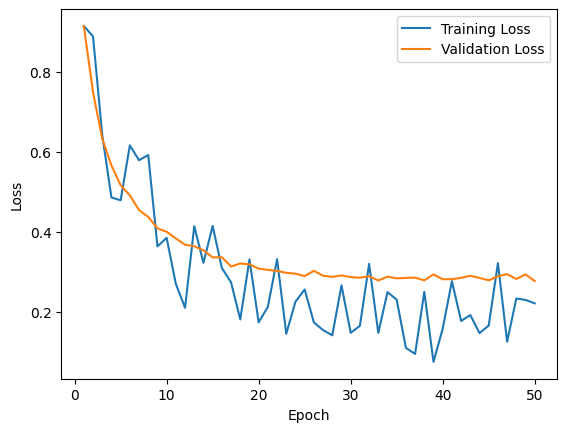

In [16]:
# 학습 및 검증 손실 시각화
plt.plot(range(1, EPOCH + 1), losses, label='Training Loss')
plt.plot(range(1, EPOCH + 1), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
# 모델 평가
with torch.no_grad():
    y_pred_test = model(X_test)  # Logits 반환
    y_pred_labels = torch.argmax(y_pred_test, dim=1)
    accuracy = (y_pred_labels == y_test).sum().item() / y_test.size(0)

print("Test Accuracy:", accuracy)


Test Accuracy: 0.9055555555555556


## 문제: 실험하기

각 레이어의 노드는 100개 일때, 아래 모델들을 실험해보세요

- HiddenLayer 1개, activation sigmoid 함수
- HiddenLayer 3개, activation sigmoid 함수
- HiddenLayer 10개, activation sigmoid 함수
- HiddenLayer 10개, activation relu 함수

Loss는 어떻게 되나요? EPOCH, Learning rate 등 하이퍼파라미터는 어떻게 설정하셨나요?

In [18]:

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# 데이터 생성
X, y = make_circles(factor=0.3, noise=0.1, n_samples=900)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)


## 유방암데이터

In [19]:

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# 유방암 데이터 로드 및 학습/검증 세트 분리
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, test_size=0.3, shuffle=True, random_state=42
)


## 와인 데이터

In [20]:
import torch
import torch.nn as nn
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

# 데이터 로드 및 학습/검증 세트 분리
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, test_size=0.3, shuffle=True, random_state=42
)
